# Chapter 7 - Combining Different Models for Ensemble Learning
1. 다수결 투표를 기반으로 하는 예측
2. 임의의 훈련 데이터 조합의 반복으로 Overfit 줄이기
3. weak learners로 부터 강한모델 생성하기

## 1 앙상블 학습
여러분류기를 활용해 최적값을 추출 ( 개별 분류기의 균형을 잡아주는, 강력한 '메타 분류기')

Decision Tree, SVM, Logistic Regression 를 활용해서 학습

개별 분류기의 레이블을 결합 후, 가장 많은 표를 얻은 y^ 레이블을 선택

<img src="https://databricks.com/wp-content/uploads/2015/01/Ensemble-example.png" align='left'><img src="https://hackpad-attachments.imgix.net/hackpad.com_Gal7qtO4fUl_p.550971_1453750253605_undefined" width='350' align = 'left'>

In [1]:
# ensemble 기법을 활용하면 '오차율'을 최소로 할 수 있다
# 개별 분류기 연산결과, 오차율이 분류기와 독립적임을 증명할 필요가 있다
from scipy.misc import comb
import math

def ensemble_error(n_classifier, error):
    k_start = math.ceil(n_classifier / 2.0)
    probs = [comb(n_classifier, k) * error**k * (1-error)**(n_classifier - k)
             for k in range(k_start, n_classifier + 1)]
    return sum(probs)

# 오차율 0.25를 갖는 11개 기본 분류기 반복 Test
# 0.25 오차율의 ensemble 결과 0.03432 가 된다 (오차율이 개선)
ensemble_error(n_classifier=11, error=0.25)

0.034327507019042969

In [2]:
# 0.0 ~ 1.01 범위내 오류연산
import numpy as np
# Base Error
error_range = np.arange(0.0, 1.01, 0.01)
# Ensemble Train
ens_errors = [ensemble_error(n_classifier=11, error=error) for error in error_range]  

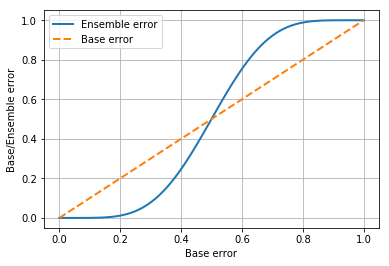

In [3]:
# 시각화
import matplotlib.pyplot as plt
plt.plot(error_range,  ens_errors, 
         label='Ensemble error', linewidth=2)

plt.plot(error_range, error_range, 
         linestyle='--', label='Base error', linewidth=2)

plt.xlabel('Base error'); plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left'); plt.grid();plt.show()

In [4]:
# 결론...
# 오차베이스 분류기 임의 추출하는 방식보다 always 성능향상이 가능

## 2 다수결 투표기 구현하기
상대다수 득표를 통한 다중분류 설정기

### 01 다수결 투표기 만들기
by Numpy

In [5]:
import numpy as np
# 가중 다수결 투표 : 인구수, GDP 등 외적인 요소를 가중치로 부과하여 다수결을 보정
# np.bincount ( [ list 선택의 종류 ], weight = [ 종류별 출현 빈도 ])
np.argmax(np.bincount([0, 0, 1],weights=[0.2, 0.2, 0.6]))

1

In [6]:
# [list] 의 조합의 결과를 가중치를 통한 평균을 계산
ex = np.array([[0.9, 0.1], [0.8, 0.2], [0.4, 0.6]])
p = np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])
p

array([ 0.58,  0.42])

In [7]:
np.argmax(p)

0

In [8]:
# A majority vote ensemble classifier
# 파라미터 ----------------------------
# classifiers : array-like, shape = [n_classifiers] Different classifiers for the ensemble
# vote : str, {'classlabel', 'probability'} (default='label')
#             (recommended for calibrated classifiers).
# weights : array-like, shape = [n_classifiers], optional (default=None)

In [9]:
# Fit classifiers
# 파라미터 -------
# X : {array-like, sparse matrix}, shape = [n_samples, n_features] Matrix of training samples.
# y : array-like, shape = [n_samples] Vector of target class labels.
# 결과값 --------
# self : object

In [10]:
# Predict class labels for X.
# 파라미터 ----------
# X : {array-like, sparse matrix}, shape = [n_samples, n_features] Matrix of training samples.
# Returns ---------
# maj_vote : array-like, shape = [n_samples] Predicted class labels.

In [11]:
# Predict class probabilities for X.
# 파라미터 ---------
# X : {array-like, sparse matrix}, shape = [n_samples, n_features], Training vectors
# Returns --------
# avg_proba : array-like, shape = [n_samples, n_classes] Weighted average probability

In [12]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np; import operator

In [13]:
# 투표를 통한 다수결 측정기
# 측정 횟수를 반복하여, 오류가 적은 조합을 추출한다
class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote=%r)" % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal'
                  '; got %d weights, %d classifiers' % (len(self.weights), len(self.classifiers)))

        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote
            predictions = np.asarray([clf.predict(X)  for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(
                lambda x: np.argmax(np.bincount(x,weights=self.weights)),
                axis=1, arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        probas = np.asarray([clf.predict_proba(X)  for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True): # Get classifier parameter names for GridSearch
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

### 02 다수결 투표 분류를 위한 알고리즘 결합
by Iris 데이터 활용

In [14]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

iris.data.shape

(150, 4)

In [15]:
# train 50%, test 50% 데이터를 분할한다
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

In [16]:
# 훈련을 위해 3개의 분류기를 활용
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# Logistic 회귀식을 활용한 분류기
clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=0)
# Decision Tree 분류기
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
# KNN 분류기
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

In [17]:
# Rogistic 과 KNN 분류기 입력값에 대한 정규화 시행
# 측정 단위가 서로다를 수 있으므로 정규화 습관을 들이자!!
pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])
clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']

In [18]:
# ensemble 분류기로 결합 전 '훈련데이터'에 대한 10-fold 교차검증 실행
# Rogistic, KNN 정규화 결과, Decision Tree만 원본 데이터 적용
print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator = clf,
                             X = X_train, y = y_train,
                             cv=10, scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.92 (+/- 0.20) [Logistic Regression]
ROC AUC: 0.92 (+/- 0.15) [Decision Tree]
ROC AUC: 0.93 (+/- 0.10) [KNN]


In [19]:
# 다수결규칙 투표를 위한 개별분류기
# Majority Rule (hard) Voting
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

clf_labels += ['Majority Voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator = clf,
                             X = X_train, y = y_train,
                             cv=10, scoring='roc_auc')
    print("ROC AUC: %0.2f (+/-%0.2f) [%s]" %(scores.mean(), scores.std(), label))

ROC AUC: 0.92 (+/-0.20) [Logistic Regression]
ROC AUC: 0.92 (+/-0.15) [Decision Tree]
ROC AUC: 0.93 (+/-0.10) [KNN]
ROC AUC: 0.97 (+/-0.10) [Majority Voting]


In [20]:
# 결과를 예측해 보면, 값들은 거의 비슷 비슷 하다
# 하지만 다수결측정기를 사용한 결과 성능이 개선된 결과를 출력한다

## 3 앙상블 분류기의 평가 및 튜닝
MajorityVoteClassifier 가 처음 경험하는 데이터에 대해서도 일반화를 잘 하는지 확인

일반화 성능에 대한 불편 추정량을 보고한다

### 01 ROC Curve를 활용한 시각화
각 분류기의 성능을 비교

In [21]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']

In [22]:
# assuming the label of the positive class is 1
for clf, label, clr, ls \
        in zip(all_clf, clf_labels, colors, linestyles):
    y_pred = clf.fit(X_train,y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true = y_test, y_score = y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr, linestyle=ls, label='%s (auc = %0.2f)' % (label, roc_auc))

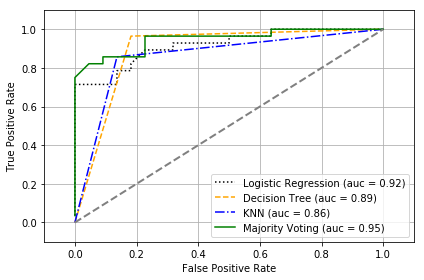

In [23]:
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1]); plt.ylim([-0.1, 1.1]); plt.grid()
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.tight_layout()
plt.show()

In [24]:
# 결과
# 로지스틱/ 앙상블 결과는 좋은 성능을 발현
# KNN은 OverFit 경향 (10회 교차훈련 0.92 > test 평가 0.86)

### 02 Decision Tree 를 시각화
Iris 데이터로 의사결정나무도 결정 영역을 시각화

In [25]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
all_clf = [pipe1, clf2, pipe3, mv_clf]

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

In [26]:
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2, 
                        sharex='col', sharey='row', figsize=(7, 5))

In [27]:
from itertools import product
for idx, clf, tt in zip(product([0, 1], [0, 1]),all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], 
                                  X_train_std[y_train==0, 1], 
                                  c = 'blue', marker = '^',s = 50)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], 
                                  X_train_std[y_train==1, 1], 
                                  c = 'red', marker = 'o',s = 50)
    
    axarr[idx[0], idx[1]].set_title(tt)

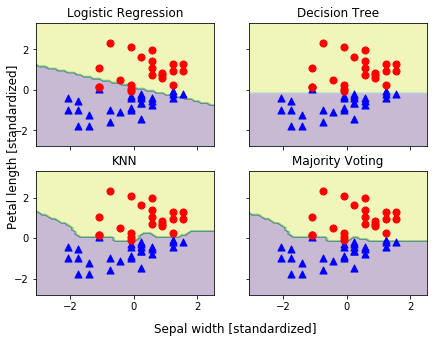

In [28]:
plt.text(-3.5, -4.5, 
         s='Sepal width [standardized]', 
         ha='center', va='center', fontsize=12)
plt.text(-10.5, 4.5, 
         s='Petal length [standardized]', 
         ha='center', va='center', 
         fontsize=12, rotation=90)
plt.show()

In [29]:
# 앙상블 분류기는 로지스틱, 의사결정나무, KNN 분류기등을 Hybride 한 모습을 볼 수 있다

### 03 Grid 검색으로, Logistic / Decision Tree 의 depth에 관한 역정규화 파라미터 'C'를 튜닝
Grid Search 오브젝트 내부 개별 parameter에 접근 방법을 익힌다

In [30]:
# mv_clf 모델의 파라미터를 확인
# mv_clf.get_params() # 여러 파라미터 변수를 확인가능

In [31]:
# GridSearchCV 파라미터를 튜닝
from sklearn.model_selection import GridSearchCV

# 변경할 파라미터
params = {'decisiontreeclassifier__max_depth': [1, 2],
          'pipeline-1__clf__C': [0.001, 0.1, 100.0]}
# 해당 파라미터를 모델과 연결
grid = GridSearchCV(estimator = mv_clf, param_grid = params,
                    cv = 10, scoring = 'roc_auc')
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=MajorityVoteClassifier(classifiers=[Pipeline(steps=[['sc', StandardScaler(copy=True, with_mean=True, with_std=True)], ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solv...ski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')]])],
            vote='classlabel', weights=None),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'decisiontreeclassifier__max_depth': [1, 2], 'pipeline-1__clf__C': [0.001, 0.1, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [32]:
cv_keys = ('mean_test_score', 'std_test_score','params')

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_[cv_keys[0]][r], 
             grid.cv_results_[cv_keys[1]][r] / 2.0, 
             grid.cv_results_[cv_keys[2]][r]))

# 반복 실험 중 최적값을 추출
print('\nBest parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
1.000 +/- 0.00 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
1.000 +/- 0.00 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}

Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
Accuracy: 1.00


## 3 Bagging : Bootstrap 샘플로부터 분류기 앙상블 만들기
'동일 훈련데이터'의 반복이 아닌, '최초 훈련데이터' 에서 bootstrap Sample 을 끌어와서 훈련

<img src="https://www.packtpub.com/graphics/9781787128576/graphics/3547_07_06.jpg" align="left" width='500'>

In [ ]:
# import Wind data
import pandas as pd

df_wine = pd.read_csv('./data/wine.data',header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

In [33]:
# drop 1 class
df_wine = df_wine[df_wine['Class label'] != 1]
y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'Hue']].values

In [35]:
# 40% test 데이터, 나머지 60% 훈련데이터
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test =\
            train_test_split(X, y, test_size=0.40, random_state=1)

In [36]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(\
             criterion='entropy', max_depth=None, random_state=1)

bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500, 
                        max_samples=1.0, max_features=1.0, 
                        bootstrap=True, bootstrap_features=False, 
                        n_jobs=-1, random_state=1)

In [37]:
from sklearn.metrics import accuracy_score

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f'
      % (tree_train, tree_test))

Decision tree train/test accuracies 1.000/0.833


In [38]:
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print('Bagging train/test accuracies %.3f/%.3f'
      % (bag_train, bag_test))

Bagging train/test accuracies 1.000/0.896


In [39]:
import numpy as np
import matplotlib.pyplot as plt

x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

In [40]:
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(8, 3))

In [41]:
for idx, clf, tt in zip([0, 1], [tree, bag], ['Decision Tree', 'Bagging']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')

    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='red', marker='o')

    axarr[idx].set_title(tt)

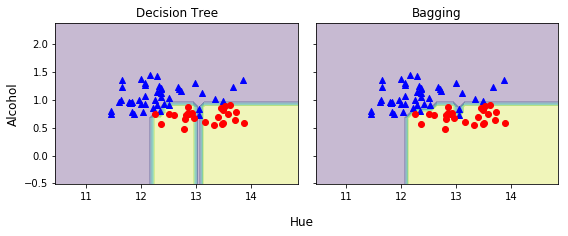

In [42]:
axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -1.2,
         s='Hue',ha='center', va='center', fontsize=12)

plt.tight_layout()
# plt.savefig('./figures/bagging_region.png',
#            dpi=300,
#            bbox_inches='tight')
plt.show()